# The Power Spectrum of Real Data

This should be re-done with a more robust fitting routine to remove flares

In [1]:
%matplotlib inline

import sys
sys.path
sys.path.append('/Users/ellie/Research/appaloosa')
from appaloosa import detrend  

from astropy.io import fits
import numpy as np
from pandas import rolling_median
import matplotlib.pyplot as plt
#from astropy.stats import lombscargle, LombScargle
import scipy.signal as signal
import math

## Read and smooth the data

In [16]:
# Read in the data for this star

f = fits.open('data/kplr009726699-2010203174610_slc.fits') ## Kepmag = 12.738 fast P, dM
#f = fits.open('data/kplr009604728-2009291181958_slc.fits') ## slowly rotating Sun, Kepmag = 10.45
#f = fits.open('data/kplr005351250-2011334093404_slc.fits') ## 15
#f = fits.open('data/kplr005542466-2011116030358_slc.fits') ## 15.6
#f = fits.open('data/kplr010801273-2009350160919_slc.fits') ## 10.6

hdu_data = f[1].data
time = hdu_data["time"]
flux = hdu_data["sap_flux"]
ferr = hdu_data["sap_flux_err"]
quality = hdu_data["sap_quality"]
exptime = np.nanmedian(time[1:]-time[:-1])

In [17]:
kepmag = f[0].header['KEPMAG']
name = f[0].header['OBJECT'].replace(' ','')
print kepmag

10.565


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version


(330.2, 330.4)

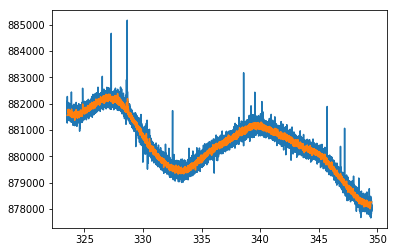

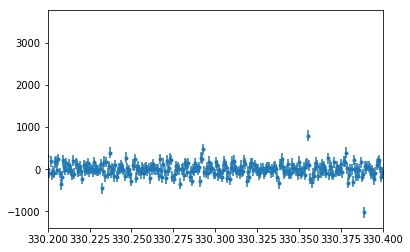

In [22]:
# Do some basic smoothing (badly)

fin, = np.where(np.isfinite(flux)*np.isfinite(ferr))
box1 = detrend.MultiBoxcar(time[fin], flux[fin], ferr[fin], kernel=2.0, numpass=2)

box_smooth = rolling_median(box1, 10, center=True)
fin = fin[np.where(np.isfinite(box_smooth))[0]]
box_smooth = box_smooth[np.where(np.isfinite(box_smooth))[0]]

plt.plot(time[fin], flux[fin])
plt.plot(time[fin], box_smooth)
#plt.ylim(266000,271000)
#plt.xlim(548.2,548.4)

plt.figure()
plt.errorbar(time[fin], flux[fin]-box_smooth, ferr[fin], fmt='.')
#plt.ylim(-500,1000)
plt.xlim(330.2,330.4)


## Plot the power spectrum

In [19]:
# frequencies for grid
freqs = 1/(10**np.linspace(-4,1,2000.))
frequency1, frequency2 = freqs, freqs

# Power spectrum of data (minus smooth component)
#frequency1, power1 = LombScargle(time[fin], flux[fin]-box_smooth).autopower()
power1 = signal.lombscargle(time[fin], flux[fin]-box_smooth, freqs, normalize=False)

# Power spectrum of noise (Gaussian noise using the median error)

myerr = np.nanmedian(ferr[fin]) ## if you scale err, power goes up by error^2 (yay)

#frequency2, power2 = LombScargle(time[fin], np.random.randn(len(fin))*myerr,normalization='psd').autopower()
power2 = signal.lombscargle(time[fin], np.random.randn(len(fin))*myerr, freqs, normalize=False)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


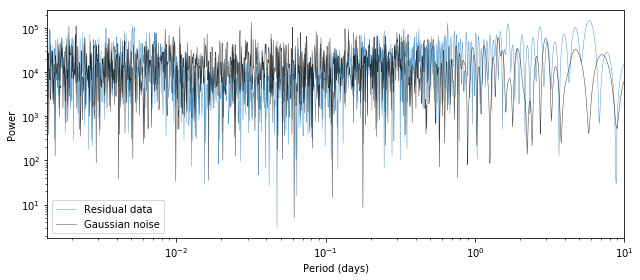

In [20]:
plt.figure(figsize=(9,4))
plt.plot(2.*math.pi/frequency1, power1, lw=0.5, alpha=0.75, label='Residual data')
plt.plot(2.*math.pi/frequency2, power2, lw=0.5, c='black', alpha=0.75, label='Gaussian noise')

plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.yscale('log')
plt.xlim(exptime*2, 10)
plt.legend()
plt.tight_layout()
plt.savefig('plots/'name+'.pdf')